In [2]:
from pycocotools.coco import COCO
from sklearn import tree, metrics
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop
from skimage import io, color
from math import floor, ceil
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import json

# import graphviz 

In [3]:
train_instance="annotations/instances_train2017.json"
val_instance="annotations/instances_val2017.json"


In [4]:
coco_path = "D:/FSR/COCO/train2017"

In [8]:
with open(train_instance, 'rb') as f:
    train_ins = json.load(f)

In [9]:
with open(val_instance, 'rb') as f:
    val_ins = json.load(f)

In [10]:
train_ins.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [11]:
type(train_ins['categories'])

list

In [12]:
type(train_ins['categories'][0])

dict

In [13]:
train_ins['categories'][0].keys()

dict_keys(['supercategory', 'id', 'name'])

In [15]:
train_ins['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [19]:
supercategory = set(x['supercategory'] for x in train_ins['categories'])

In [21]:
{x['name']:x['id'] for x in train_ins['categories']}

{'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'airplane': 5,
 'bus': 6,
 'train': 7,
 'truck': 8,
 'boat': 9,
 'traffic light': 10,
 'fire hydrant': 11,
 'stop sign': 13,
 'parking meter': 14,
 'bench': 15,
 'bird': 16,
 'cat': 17,
 'dog': 18,
 'horse': 19,
 'sheep': 20,
 'cow': 21,
 'elephant': 22,
 'bear': 23,
 'zebra': 24,
 'giraffe': 25,
 'backpack': 27,
 'umbrella': 28,
 'handbag': 31,
 'tie': 32,
 'suitcase': 33,
 'frisbee': 34,
 'skis': 35,
 'snowboard': 36,
 'sports ball': 37,
 'kite': 38,
 'baseball bat': 39,
 'baseball glove': 40,
 'skateboard': 41,
 'surfboard': 42,
 'tennis racket': 43,
 'bottle': 44,
 'wine glass': 46,
 'cup': 47,
 'fork': 48,
 'knife': 49,
 'spoon': 50,
 'bowl': 51,
 'banana': 52,
 'apple': 53,
 'sandwich': 54,
 'orange': 55,
 'broccoli': 56,
 'carrot': 57,
 'hot dog': 58,
 'pizza': 59,
 'donut': 60,
 'cake': 61,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'bed': 65,
 'dining table': 67,
 'toilet': 70,
 'tv': 72,
 'laptop': 73,
 'mouse'

In [22]:
k = '000000500663.jpg'
l = '500663'
k.__contains__(l)

True

In [23]:
type(train_ins['annotations'])

list

In [24]:
type(train_ins['annotations'][0])

dict

In [25]:
train_ins['annotations'][0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [26]:
datas = pd.DataFrame(train_ins['images'])

In [27]:
datas.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895
1,4,000000522418.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c...,522418
2,3,000000184613.jpg,http://images.cocodataset.org/train2017/000000...,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_...,184613
3,3,000000318219.jpg,http://images.cocodataset.org/train2017/000000...,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_...,318219
4,3,000000554625.jpg,http://images.cocodataset.org/train2017/000000...,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_...,554625


In [33]:
datas[datas.file_name.str.contains('391895')]

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,000000391895.jpg,http://images.cocodataset.org/train2017/000000...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895


In [45]:
datas[datas.file_name.str.contains('391895')].file_name.values[0]

'000000391895.jpg'

In [46]:
from pathlib import Path

In [47]:
root_path = Path(coco_path)

In [48]:
img_path = datas[datas.file_name.str.contains('391895')].file_name.values[0]

In [49]:
root_path/img_path

WindowsPath('D:/FSR/COCO/train2017/000000391895.jpg')

In [52]:
str(root_path/img_path)

'D:\\FSR\\COCO\\train2017\\000000391895.jpg'

In [53]:
annotation_df = pd.DataFrame(train_ins['annotations'])

In [54]:
annotation_df.head

Index(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id',
       'id'],
      dtype='object')

In [56]:
annotation_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",2765.14865,0,558840,"[199.84, 200.46, 77.71, 70.88]",58,156
1,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",1545.42130,0,200365,"[234.22, 317.11, 149.39, 38.55]",58,509
2,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",5607.66135,0,200365,"[239.48, 347.87, 160.0, 57.81]",58,603
3,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",0.00000,0,200365,"[296.65, 388.33, 1.03, 0.0]",58,918
4,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",800.41325,0,200365,"[251.87, 333.42, 125.94, 22.71]",58,1072


In [66]:
k = annotation_df[annotation_df.category_id==58][['image_id', 'bbox']]

In [64]:
x, y, w, h = [199.84, 200.46, 77.71, 70.88]

In [83]:
k.head()

,image_id,bbox
0,558840,"[199.84, 200.46, 77.71, 70.88]"
1,200365,"[234.22, 317.11, 149.39, 38.55]"
2,200365,"[239.48, 347.87, 160.0, 57.81]"
3,200365,"[296.65, 388.33, 1.03, 0.0]"
4,200365,"[251.87, 333.42, 125.94, 22.71]"


In [87]:
for r in k.itertuples():
    print(r)

44965, bbox=[353.76, 264.57, 83.54, 91.39])
Pandas(Index=849899, image_id=199188, bbox=[151.96, 111.73, 88.32, 113.69])
Pandas(Index=849900, image_id=559695, bbox=[197.69, 162.99, 48.16, 39.29])
Pandas(Index=849901, image_id=444107, bbox=[304.67, 244.68, 70.33, 92.37])
Pandas(Index=849902, image_id=572441, bbox=[106.22, 126.91, 291.33, 200.88])
Pandas(Index=849903, image_id=230334, bbox=[483.0, 189.16, 6.44, 16.26])
Pandas(Index=849904, image_id=417867, bbox=[240.28, 128.92, 109.19, 100.64])
Pandas(Index=849905, image_id=371489, bbox=[605.63, 139.49, 34.37, 28.44])
Pandas(Index=849906, image_id=408946, bbox=[77.71, 186.6, 223.43, 185.78])
Pandas(Index=849907, image_id=99788, bbox=[292.01, 101.23, 174.51, 59.68])
Pandas(Index=849908, image_id=456369, bbox=[0.0, 423.8, 74.54, 108.69])
Pandas(Index=849909, image_id=549166, bbox=[106.09, 255.35, 29.75, 31.48])
Pandas(Index=849910, image_id=200971, bbox=[197.51, 252.52, 27.32, 39.26])
Pandas(Index=849911, image_id=226681, bbox=[72.57, 0.0, 

In [86]:
r

Pandas(Index=859550, image_id=72898, bbox=[90, 209, 543, 131])

In [127]:
x, y, w, h = list(map(int, r.bbox))
print(x, y, w, h)

90 209 543 131


In [91]:
r.image_id

72898

In [92]:
r.bbox

[90, 209, 543, 131]

In [93]:
type(r)

pandas.core.frame.Pandas

In [97]:
from LoadLocalCOCO import LoadLocalCOCO as llc

In [98]:
dir(llc)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_crop_image',
 '_get_image_by_id',
 'get_category_id',
 'get_cropped_images']

In [99]:
ob_llc = llc(train_instance, coco_path)

In [101]:
images = ob_llc.get_cropped_images('cat')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [128]:
import cv2
class LoadLocalCOCO:
    def __init__(self, file_path, coco_root):
        with open(file_path, 'rb') as f:
            self.data =json.load(f)
        self.supercategories = set(x['supercategory'] for x in self.data['categories'])
        self.categories = {x['name']:x['id'] for x in self.data['categories']}
        self.id_categories = {x['id']: x['name'] for x in self.data['categories']}
        self.image_df = pd.DataFrame(self.data['images'])
        self.annotation_df = pd.DataFrame(self.data['annotations'])
        self.root_folder = Path(coco_root)

    def get_category_id(self, category_name) -> str:
        return self.categories[category_name]

    def _get_image_by_id(self, image_id):
        image_path = self.image_df[self.image_df.file_name.str.contains(str(image_id))].file_name.values[0]
        image = cv2.imread(str(self.root_folder/image_path))
        return image

    def get_cropped_images(self, category_name) -> list:
        idx_cat = self.get_category_id(category_name)
        images = []
        image_ids = self.annotation_df[self.annotation_df.category_id==idx_cat][['image_id', 'bbox']]
        for frames in image_ids.itertuples():
            print(frames)
            image = self._get_image_by_id(frames.image_id)
            image = self._crop_image(image, frames.bbox)
            images.append(image)
        return images

    @staticmethod
    def _crop_image(image, bbox):
        x, y, w, h = list(map(int, bbox))
        return image[y:y+h,x:x+w]

In [129]:
ob_llc = LoadLocalCOCO(train_instance, coco_path)

In [130]:
ob_llc.get_category_id('cat')

17

In [131]:
ob_llc.get_cropped_images('cat')

66, image_id=262984, bbox=[28.13, 25.37, 263.7, 438.17])
Pandas(Index=740968, image_id=553371, bbox=[427.98, 256.25, 186.17, 156.99])
Pandas(Index=740970, image_id=511239, bbox=[255.8, 90.4, 207.93, 123.1])
Pandas(Index=740971, image_id=333929, bbox=[279.46, 149.69, 81.94, 102.62])
Pandas(Index=740972, image_id=79445, bbox=[0.0, 77.66, 320.61, 348.34])
Pandas(Index=740974, image_id=51296, bbox=[199.68, 1.95, 297.07, 367.21])
Pandas(Index=740976, image_id=209288, bbox=[87.78, 210.35, 137.58, 158.69])
Pandas(Index=740977, image_id=299163, bbox=[434.2, 299.73, 25.39, 26.93])
Pandas(Index=740978, image_id=31230, bbox=[281.86, 368.7, 78.97, 65.7])
Pandas(Index=740979, image_id=201261, bbox=[389.89, 300.04, 44.3, 41.1])
Pandas(Index=740980, image_id=336990, bbox=[30.3, 38.47, 153.9, 137.96])
Pandas(Index=740981, image_id=453472, bbox=[2.49, 31.17, 465.04, 448.83])
Pandas(Index=740982, image_id=36559, bbox=[29.87, 9.42, 345.13, 483.11])
Pandas(Index=740983, image_id=40348, bbox=[157.56, 178.5

 ...,
         [ 83, 123, 152],
         [ 93, 133, 162],
         [ 83, 125, 154]],
 
        [[ 22,  55, 104],
         [ 24,  56, 105],
         [ 29,  61, 110],
         ...,
         [ 85, 121, 151],
         [ 88, 126, 156],
         [ 83, 121, 151]],
 
        ...,
 
        [[ 44,  34,  27],
         [ 18,  20,  38],
         [ 52,  78, 124],
         ...,
         [ 62, 140, 211],
         [ 57, 133, 205],
         [ 51, 127, 199]],
 
        [[ 43,  34,  24],
         [ 23,  19,  31],
         [ 55,  71, 118],
         ...,
         [ 52, 126, 198],
         [ 60, 132, 204],
         [ 69, 140, 214]],
 
        [[ 48,  38,  28],
         [ 36,  28,  39],
         [ 47,  60, 104],
         ...,
         [ 54, 126, 198],
         [ 63, 135, 207],
         [ 49, 122, 196]]], dtype=uint8),
 array([[[ 90, 154, 179],
         [ 91, 154, 175],
         [ 92, 155, 176],
         ...,
         [193, 162, 131],
         [193, 162, 131],
         [196, 159, 131]],
 
        [[ 89, 155, 

In [132]:
ob_llc._get_image_by_id(str(304447))

array([[[152, 159, 168],
        [152, 159, 168],
        [153, 160, 169],
        ...,
        [  5,   5,   5],
        [  5,   5,   5],
        [  5,   5,   5]],

       [[152, 159, 168],
        [153, 160, 169],
        [153, 160, 169],
        ...,
        [  5,   5,   5],
        [  5,   5,   5],
        [  5,   5,   5]],

       [[152, 159, 168],
        [153, 160, 169],
        [154, 161, 170],
        ...,
        [  5,   6,   4],
        [  5,   6,   4],
        [  5,   6,   4]],

       ...,

       [[148, 152, 163],
        [149, 153, 164],
        [148, 154, 165],
        ...,
        [135, 140, 139],
        [132, 137, 136],
        [130, 135, 134]],

       [[148, 152, 163],
        [147, 153, 164],
        [147, 153, 166],
        ...,
        [133, 138, 137],
        [131, 136, 135],
        [128, 134, 133]],

       [[147, 153, 166],
        [147, 153, 166],
        [144, 152, 165],
        ...,
        [132, 137, 136],
        [130, 135, 134],
        [128, 134, 133]]

In [133]:
data_images_df = ob_llc.get_cropped_images('cat')

66, image_id=262984, bbox=[28.13, 25.37, 263.7, 438.17])
Pandas(Index=740968, image_id=553371, bbox=[427.98, 256.25, 186.17, 156.99])
Pandas(Index=740970, image_id=511239, bbox=[255.8, 90.4, 207.93, 123.1])
Pandas(Index=740971, image_id=333929, bbox=[279.46, 149.69, 81.94, 102.62])
Pandas(Index=740972, image_id=79445, bbox=[0.0, 77.66, 320.61, 348.34])
Pandas(Index=740974, image_id=51296, bbox=[199.68, 1.95, 297.07, 367.21])
Pandas(Index=740976, image_id=209288, bbox=[87.78, 210.35, 137.58, 158.69])
Pandas(Index=740977, image_id=299163, bbox=[434.2, 299.73, 25.39, 26.93])
Pandas(Index=740978, image_id=31230, bbox=[281.86, 368.7, 78.97, 65.7])
Pandas(Index=740979, image_id=201261, bbox=[389.89, 300.04, 44.3, 41.1])
Pandas(Index=740980, image_id=336990, bbox=[30.3, 38.47, 153.9, 137.96])
Pandas(Index=740981, image_id=453472, bbox=[2.49, 31.17, 465.04, 448.83])
Pandas(Index=740982, image_id=36559, bbox=[29.87, 9.42, 345.13, 483.11])
Pandas(Index=740983, image_id=40348, bbox=[157.56, 178.5

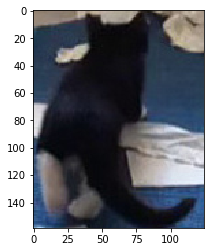

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

rgb_img = cv2.cvtColor(data_images_df[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

In [136]:
rgb_img.flatten()

array([146, 130, 114, ...,  47,  88, 140], dtype=uint8)

In [137]:
help(cv2.resize)

Help on built-in function resize:

resize(...)
    resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) -> dst
    .   @brief Resizes an image.
    .   
    .   The function resize resizes the image src down to or up to the specified size. Note that the
    .   initial dst type or size are not taken into account. Instead, the size and type are derived from
    .   the `src`,`dsize`,`fx`, and `fy`. If you want to resize src so that it fits the pre-created dst,
    .   you may call the function as follows:
    .   @code
    .       // explicitly specify dsize=dst.size(); fx and fy will be computed from that.
    .       resize(src, dst, dst.size(), 0, 0, interpolation);
    .   @endcode
    .   If you want to decimate the image by factor of 2 in each direction, you can call the function this
    .   way:
    .   @code
    .       // specify fx and fy and let the function compute the destination image size.
    .       resize(src, dst, Size(), 0.5, 0.5, interpolation);
    .   @endcode


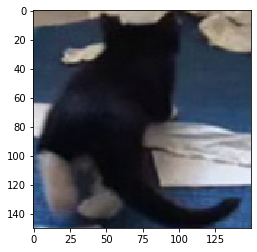

In [140]:
rgb_img_resized = cv2.resize(rgb_img, (150, 150))
plt.imshow(rgb_img_resized)

In [141]:
cv2.resize(rgb_img, (150, 150)).flatten()

array([146, 130, 114, ...,  47,  88, 140], dtype=uint8)

In [143]:
len(ob_llc.annotation_df[ob_llc.annotation_df.category_id==17].index)

4768

In [145]:
'AHUAS'.lower()

'ahuas'

In [151]:
listasd = [[[1],2,3],[ 4,5,1]]

In [152]:
[y for x in listasd for y in x]

[[1], 2, 3, 4, 5, 1]

In [156]:
np.shape(rgb_img_resized)

(150, 150, 3)